<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/CHP_Landsat_ANN_simple_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8 y 5

* Se usa Keras 2.13 y tensorflow 2.13, para esto se desinstala la actual version 3 - por corregir
* Version con re-entrenamiento del modelo pre-entrenado
* Versión con la estandarizaciíón de datos con StandardScaler
* Version con un post-entranemiento del modelo pre-entrenado
* Clasificación en tres clases (no-urbano, urbano, agua)

In [1]:
!pip uninstall tensorflow
!pip3 install tensorflow==2.13

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 33.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing

In [1]:


!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [2]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [4]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/CHP_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/CHP_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/CHP_2020_feature_L8_6b.npy')
array_feature_2011 = np.load('/content/drive/MyDrive/Colab Data/CHP_2011_feature_L5_6b.npy')
array_feature_2010 = np.load('/content/drive/MyDrive/Colab Data/CHP_2010_feature_L5_6b.npy')
array_feature_2000 = np.load('/content/drive/MyDrive/Colab Data/CHP_2000_feature_L5_6b.npy')
array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/CHP_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/CHP_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [5]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [6]:
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2020 = feature_transform(array_feature_2020)
x_features_2011 = feature_transform(array_feature_2011)
x_features_2010 = feature_transform(array_feature_2010)
x_features_2000 = feature_transform(array_feature_2000)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(1, 234, 645)
(150930, 1)
(1, 234, 645)
(150930, 1)


Estandarización de datos

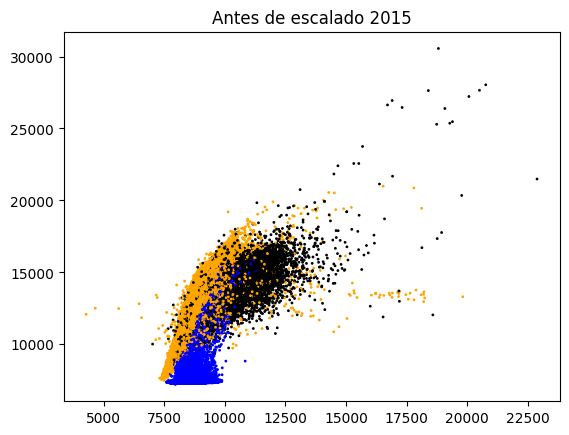

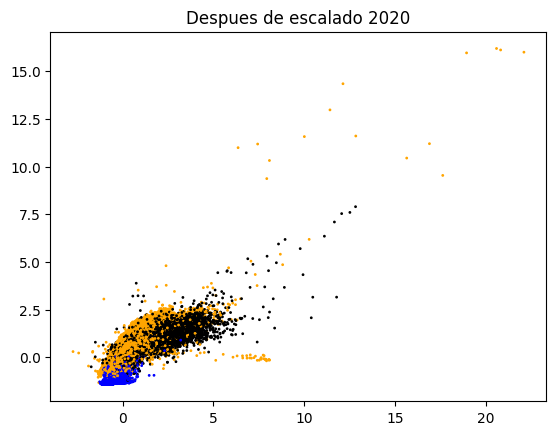

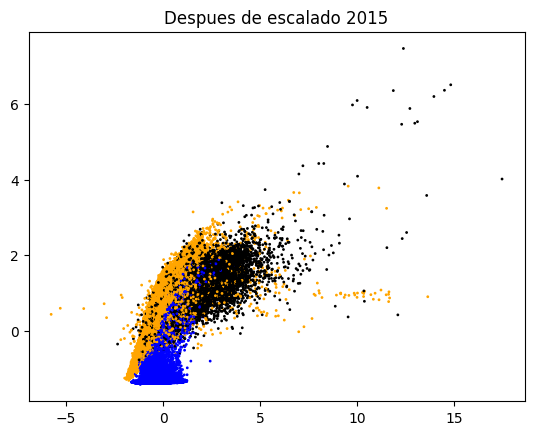

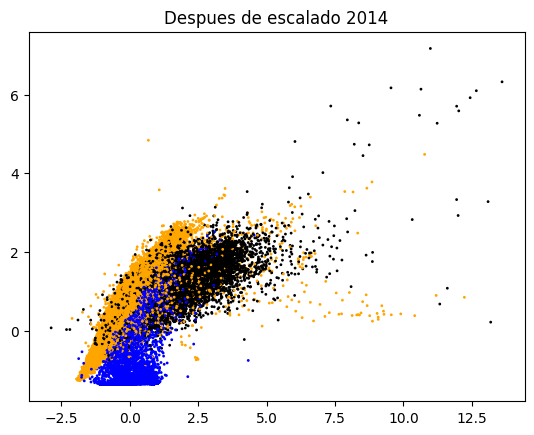

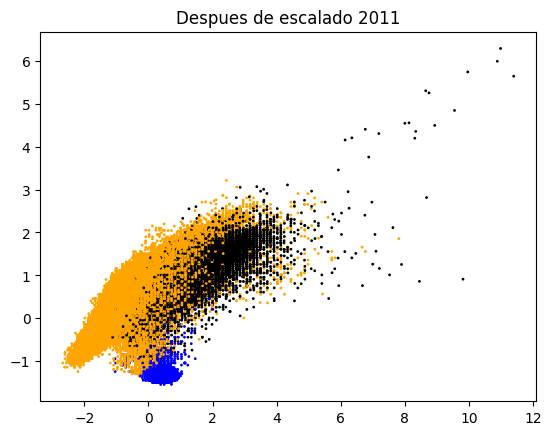

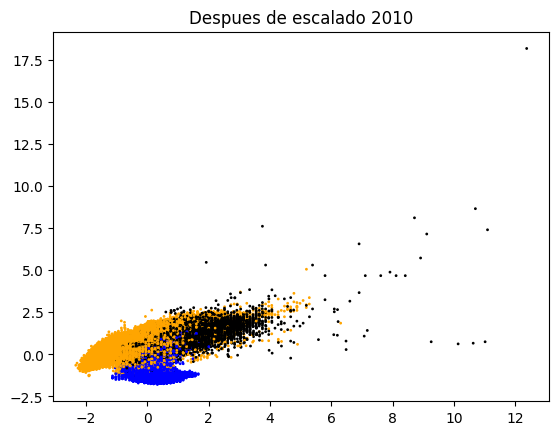

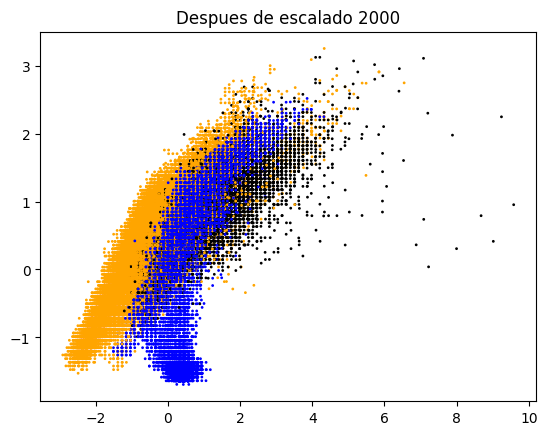

In [7]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(0,150930)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2020 = scale.fit_transform(x_features_2020)
x_features_2011 = scale.fit_transform(x_features_2011)
x_features_2010 = scale.fit_transform(x_features_2010)
x_features_2000 = scale.fit_transform(x_features_2000)

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2011[rango,0], x_features_2011[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2011')
plt.show()

plt.scatter(x_features_2010[rango,0], x_features_2010[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2010')
plt.show()

plt.scatter(x_features_2000[rango,0], x_features_2000[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2000')
plt.show()

In [8]:
print(x_features_2015)
print(y_labels_2015)

[[ 0.73324324  0.98116103  1.79653454  1.2699621   1.87713955  1.7875657 ]
 [ 0.53696815  0.5713919   1.51541929  1.03984612  1.58992771  1.59273453]
 [ 0.25568219  0.24105792  0.85134765  0.84793472  1.23173823  1.26471798]
 ...
 [-1.08948979  0.09574971 -0.62156157 -1.62410915 -1.49072188 -1.37235244]
 [-1.06448659  0.09090611 -0.61230329 -1.62618227 -1.49264763 -1.36892768]
 [-1.05948595  0.10931181 -0.60893664 -1.62558995 -1.49374806 -1.36778609]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


Subdividir datos de entrenamiento y control (2015)

In [9]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.2, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(120744, 6)
(120744, 1)
(30186, 6)
(30186, 1)
[[ 0.69948892  0.50745629  1.30163704  0.75938301  1.43064069  1.48732782]
 [ 0.16067004  0.46483255  1.07438819  2.18479899  1.13517563  0.88799363]
 [-0.44940796 -0.46223378  0.17044276  0.15610598  0.34121647  0.34916366]
 ...
 [ 0.35694513  0.42027137  0.46923291  1.30402045  0.92664443  0.70267569]
 [ 1.8671382   1.71157692  2.15760771  1.79564532  1.1106911   1.08853275]
 [ 0.82825539  1.03347198  0.19905928 -1.3469038  -1.43239917 -1.34761802]]
[[0]
 [2]
 [0]
 ...
 [0]
 [2]
 [1]]
(120744, 1, 6) (30186, 1, 6)


Continuar entrenamiento de la red neuronal (ANN) simple pre-entrenada

In [10]:
from tensorflow import keras
from keras.models import load_model

#print(keras.__version__)

## Cargar un modelo preentrenado
#model = load_model('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')
model = load_model('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')

print(model.summary())

# Continuar entrenamiento del modelo con datos adicionales
model.fit(xTrain, yTrain, epochs=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
3774/3774 [==============================] - 7s 2ms/step - loss: 0.1502 - accuracy: 0.9442
Epoch 2/5
3774/3774 [==============================]

In [11]:
model.save('/content/drive/MyDrive/Colab Data/CHP_2015_model_ANN_2hl_3class_posentrenado.tensorflow')

In [12]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

944/944 [==============================] - 1s 1ms/step


In [13]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[17982    43   541]
 [  233  8364    61]
 [  624    26  2312]]

Exactitud (accuracy): 0.949,

Kappa de Cohen: 0.904,

Clase 1. Selectividad (precision): 0.955, especificidad (recall): 0.969, f1: 0.961

Clase 2. Selectividad (precision): 0.992, especificidad (recall): 0.966, f1: 0.979

Clase 3. Selectividad (precision): 0.793, especificidad (recall): 0.781, f1: 0.787


Predicción para datos de 2015

In [14]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

4717/4717 [==============================] - 8s 2ms/step
[[9.9332982e-01 4.9646100e-05 6.6205123e-03]
 [9.9311525e-01 1.7770084e-05 6.8670111e-03]
 [9.8325926e-01 1.9571627e-04 1.6544947e-02]
 ...
 [1.1429729e-07 9.9999982e-01 3.7024130e-26]
 [1.2241851e-07 9.9999988e-01 5.4461145e-26]
 [1.0851338e-07 9.9999988e-01 3.6931315e-26]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

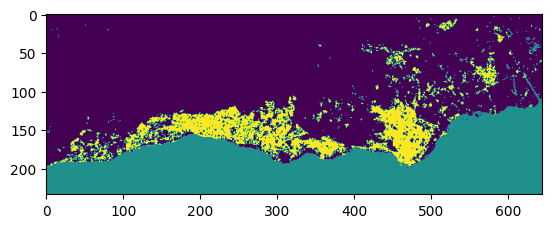

In [15]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

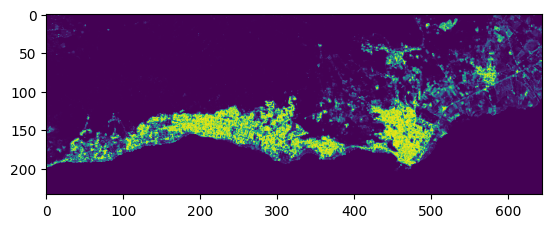

In [16]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [17]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

4717/4717 [==============================] - 7s 1ms/step
[[8.0330592e-01 1.4074356e-04 1.9655335e-01]
 [9.8177731e-01 1.9279563e-04 1.8029934e-02]
 [9.3256533e-01 1.0842326e-02 5.6592230e-02]
 ...
 [1.2029241e-07 9.9999982e-01 2.5683413e-22]
 [2.0963029e-07 9.9999976e-01 9.4578521e-22]
 [1.6196071e-07 9.9999988e-01 4.4217610e-22]]


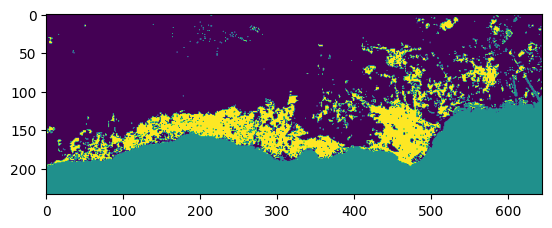

In [18]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

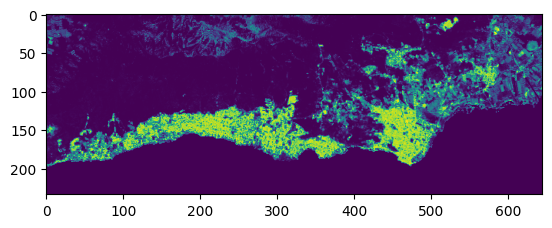

In [19]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [20]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

4717/4717 [==============================] - 8s 2ms/step
[[9.9835002e-01 2.9494173e-05 1.6205298e-03]
 [9.9635381e-01 2.3584039e-04 3.4103740e-03]
 [9.9818796e-01 1.4049413e-04 1.6714820e-03]
 ...
 [1.2029678e-07 9.9999982e-01 3.4968148e-25]
 [1.1779365e-07 9.9999988e-01 4.4509978e-25]
 [1.3434880e-07 9.9999988e-01 7.5139716e-25]]


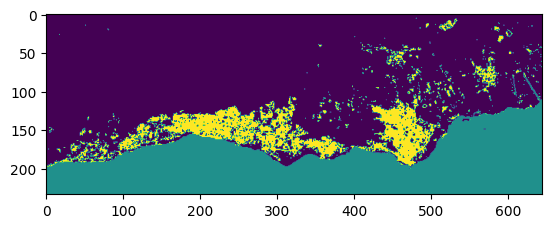

In [21]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

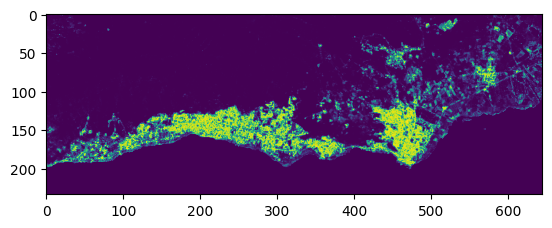

In [22]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [23]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/CHP_2014_prediction_class.npy', predicted_2014_class_re)
np.save('/content/drive/MyDrive/Colab Data/CHP_2015_prediction_class.npy', predicted_2015_class_re)
np.save('/content/drive/MyDrive/Colab Data/CHP_2020_prediction_class.npy', predicted_2020_class_re)
np.save('/content/drive/MyDrive/Colab Data/CHP_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/CHP_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/CHP_2020_prediction_urbano_float.npy', prediction_2020_urbano)

Preparar datos binarios 2014 para uso como target en modelo L5

In [24]:
x_features_2011_n = x_features_2011
x_features_2011_n = x_features_2011_n.reshape((x_features_2011_n.shape[0], 1, x_features_2011_n.shape[1]))

y_target_2011_n = predicted_2014_class.reshape(x_features_2014_n.shape[0], 1)

print(x_features_2011_n.shape, y_target_2011_n.shape)

(150930, 1, 6) (150930, 1)


Posentrenar modelo L5

In [25]:
## Cargar un modelo preentrenado
model1 = load_model('/content/drive/MyDrive/Colab Data/GDL_2011_model_ANN_2hl_3class.tensorflow')

print(model1.summary())

# Posentrenar con datos 2011
model1.fit(x_features_2011_n, y_target_2011_n, epochs=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 20)                140       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
4717/4717 [==============================] - 11s 2ms/step - loss: 0.1397 - accuracy: 0.9473
Epoch 2/5
4717/4717 [============================

In [26]:
model.save('/content/drive/MyDrive/Colab Data/CHP_2011_model_ANN_2hl_3class_posentrenado.tensorflow')

Prediccion 2011

In [27]:
predicted_2011 = model1.predict(x_features_2011_n)
print(predicted_2011)

4717/4717 [==============================] - 7s 1ms/step
[[9.9855763e-01 4.3734838e-07 1.4419458e-03]
 [9.9511975e-01 4.8524416e-06 4.8753056e-03]
 [9.9429053e-01 5.3457115e-05 5.6559327e-03]
 ...
 [7.7398305e-05 9.9991459e-01 8.0011050e-06]
 [1.4586952e-04 9.9983883e-01 1.5302463e-05]
 [8.1332109e-04 9.9913639e-01 5.0216589e-05]]


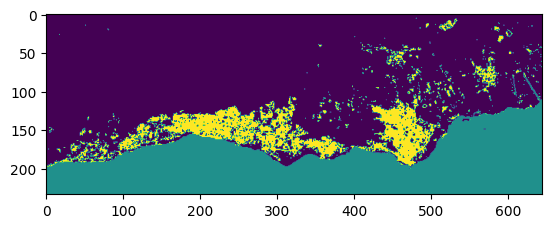

In [28]:
predicted_2011_class = predicted_2011.argmax(axis=-1)
predicted_2011_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2011_class_re[:,:])
plt.show()

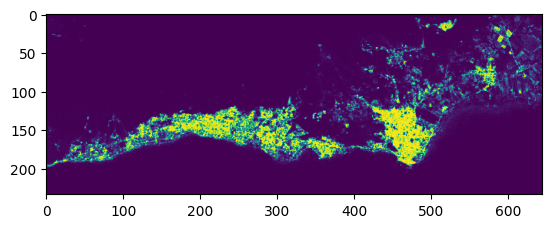

In [29]:
prediction_2011_urbano = np.reshape(predicted_2011[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2011 = (prediction_2011_urbano).astype('float')
plt.imshow(B_img_pred_2011[:,:])
plt.show()

Prediccion 2010

In [30]:
x_features_2010_n = x_features_2010
x_features_2010_n = x_features_2010_n.reshape((x_features_2010_n.shape[0], 1, x_features_2010_n.shape[1]))

predicted_2010 = model1.predict(x_features_2010_n)
print(predicted_2010)

4717/4717 [==============================] - 6s 1ms/step
[[9.9865097e-01 4.6012229e-07 1.3486379e-03]
 [9.9740982e-01 3.2994110e-06 2.5867422e-03]
 [9.9224186e-01 6.2933796e-05 7.6951073e-03]
 ...
 [2.1051399e-03 9.9512541e-01 2.7693720e-03]
 [2.1130934e-03 9.9500507e-01 2.8818962e-03]
 [3.8515285e-03 9.9159449e-01 4.5539602e-03]]


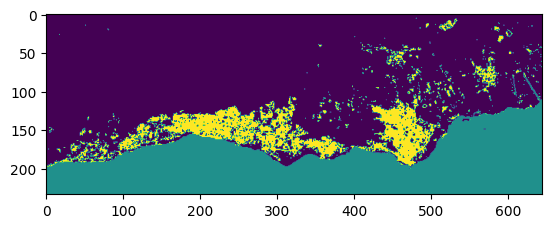

In [31]:
predicted_2010_class = predicted_2010.argmax(axis=-1)
predicted_2010_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2010_class_re[:,:])
plt.show()

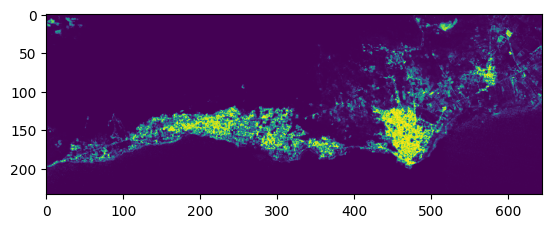

In [32]:
prediction_2010_urbano = np.reshape(predicted_2010[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2010 = (prediction_2010_urbano).astype('float')
plt.imshow(B_img_pred_2010[:,:])
plt.show()

Prediccion 2000

In [33]:
x_features_2000_n = x_features_2000
x_features_2000_n = x_features_2000_n.reshape((x_features_2000_n.shape[0], 1, x_features_2000_n.shape[1]))

predicted_2000 = model1.predict(x_features_2000_n)
print(predicted_2000)

4717/4717 [==============================] - 7s 2ms/step
[[9.9516237e-01 8.5799635e-05 4.7517759e-03]
 [9.9673158e-01 5.8324538e-05 3.2100577e-03]
 [9.9090064e-01 7.5577373e-05 9.0237102e-03]
 ...
 [4.7915964e-03 9.9481946e-01 3.8901070e-04]
 [2.7363003e-06 9.9999702e-01 2.8772209e-07]
 [1.5558620e-05 9.9998331e-01 1.1302466e-06]]


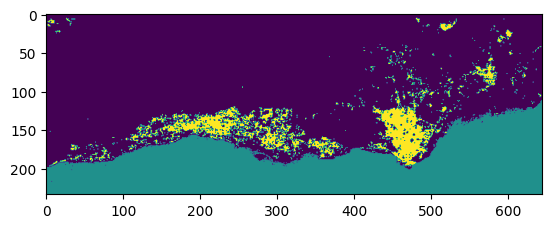

In [34]:
predicted_2000_class = predicted_2000.argmax(axis=-1)
predicted_2000_class_re = np.reshape(predicted_2010_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2000_class_re[:,:])
plt.show()

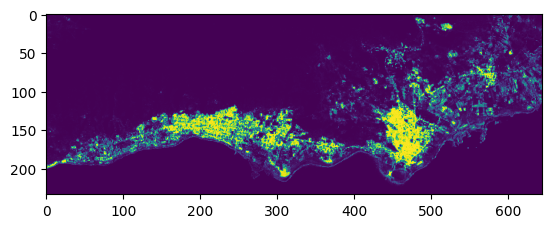

In [35]:
prediction_2000_urbano = np.reshape(predicted_2000[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2000 = (prediction_2000_urbano).astype('float')
plt.imshow(B_img_pred_2000[:,:])
plt.show()

In [36]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/CHP_2011_prediction_class.npy', predicted_2011_class_re)
np.save('/content/drive/MyDrive/Colab Data/CHP_2010_prediction_class.npy', predicted_2010_class_re)
np.save('/content/drive/MyDrive/Colab Data/CHP_2000_prediction_class.npy', predicted_2000_class_re)
np.save('/content/drive/MyDrive/Colab Data/CHP_2011_prediction_urbano_float.npy', prediction_2011_urbano)
np.save('/content/drive/MyDrive/Colab Data/CHP_2010_prediction_urbano_float.npy', prediction_2010_urbano)
np.save('/content/drive/MyDrive/Colab Data/CHP_2000_prediction_urbano_float.npy', prediction_2000_urbano)